In [1]:
import pymysql
from sqlalchemy import create_engine
import pandas as pd
import getpass
password = getpass.getpass()


········


In [2]:
connection_string = "mysql+pymysql://root:" + password + '@localhost/bank'
engine = create_engine(connection_string)

query = """
SELECT 
    t.type,
    t.operation,
    t.amount AS t_amount,
    t.balance,
    t.k_symbol,
    l.amount AS l_amount,
    l.duration,
    l.payments,
    l.status
FROM
    trans t
        LEFT JOIN
    loan l ON t.account_id = l.account_id;
"""

In [3]:
data = pd.read_sql_query(query, engine)

In [4]:
data.head(20)

,type,operation,t_amount,balance,k_symbol,l_amount,duration,payments,status
0,PRIJEM,VKLAD,700.0,700.0,,NaN,NaN,NaN,None
1,PRIJEM,VKLAD,900.0,900.0,,NaN,NaN,NaN,None
2,PRIJEM,VKLAD,1000.0,1000.0,,NaN,NaN,NaN,None
3,PRIJEM,VKLAD,600.0,600.0,,NaN,NaN,NaN,None
4,PRIJEM,VKLAD,400.0,400.0,,NaN,NaN,NaN,None
5,PRIJEM,VKLAD,1100.0,1100.0,,NaN,NaN,NaN,None
6,PRIJEM,VKLAD,600.0,600.0,,NaN,NaN,NaN,None
7,PRIJEM,VKLAD,1100.0,1100.0,,NaN,NaN,NaN,None
8,PRIJEM,VKLAD,200.0,200.0,,NaN,NaN,NaN,None
9,PRIJEM,VKLAD,800.0,800.0,,NaN,NaN,NaN,None


# EDA

In [5]:
# check null values
data.isna().sum()

type              0
operation         0
t_amount          0
balance           0
k_symbol          0
l_amount     711938
duration     711938
payments     711938
status       711938
dtype: int64

In [6]:
# check length
len(data)

868019

In [7]:
# exclude null values from the duration column(filter out)
data = data[~data['duration'].isna()]

In [8]:
# test
data.isna().sum()

type         0
operation    0
t_amount     0
balance      0
k_symbol     0
l_amount     0
duration     0
payments     0
status       0
dtype: int64

In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 156081 entries, 62 to 868011
Data columns (total 9 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   type       156081 non-null  object 
 1   operation  156081 non-null  object 
 2   t_amount   156081 non-null  float64
 3   balance    156081 non-null  float64
 4   k_symbol   156081 non-null  object 
 5   l_amount   156081 non-null  float64
 6   duration   156081 non-null  float64
 7   payments   156081 non-null  float64
 8   status     156081 non-null  object 
dtypes: float64(5), object(4)
memory usage: 11.9+ MB


In [10]:
# turning duration into categorical, because it comes in values of whole years (1,2,3,4,5)
data['duration'] = data['duration'].astype('object')

## Cleaning categoricals

### Operation column

In [11]:
# check what unique values we have
data['operation'].value_counts()

VYBER             70189
                  31337
PREVOD NA UCET    25796
VKLAD             22633
PREVOD Z UCTU      5336
VYBER KARTOU        790
Name: operation, dtype: int64

In [12]:
### We want to squash the two vyber and prevod values and name the unnamed values unknown

In [13]:
def clean_operation(x):
    x = x.lower()
    if 'vyber' in x:
        return 'vyber'
    elif 'prevod' in x:
        return 'prevod'
    elif 'vklad' in x:
        return 'vklad'
    else: 
        return 'unknown'

In [14]:
#test 
data['operation'].apply(clean_operation).value_counts()

vyber      70979
unknown    31337
prevod     31132
vklad      22633
Name: operation, dtype: int64

In [15]:
#make it permanent
data['operation'] = data['operation'].apply(clean_operation)

In [16]:
# test
data['operation'].value_counts()

vyber      70979
unknown    31337
prevod     31132
vklad      22633
Name: operation, dtype: int64

### K_symbol column

In [17]:
# check what unique values we have
data['k_symbol'].value_counts().index

Index(['', 'UROK', 'SLUZBY', 'SIPO', 'UVER', ' ', 'POJISTNE', 'SANKC. UROK'], dtype='object')

In [18]:
## celan the k_symbol values
def clean_kysmbol(x):
    if x in ['',' ']:
        return 'unknown'
    else: 
        return x

In [19]:
#make it permanent
data['k_symbol'] = data['k_symbol'].apply(clean_kysmbol)

In [20]:
# test
data['k_symbol'].value_counts()

unknown        79925
UROK           31337
SLUZBY         23592
SIPO           10482
UVER            7744
POJISTNE        2412
SANKC. UROK      589
Name: k_symbol, dtype: int64

In [21]:
# exclude rows which has 'POJISTINE', 'SANKC. UROK' or 'UVER' as values
data = data[~data['k_symbol'].isin(['POJISTNE', 'SANKC. UROK', 'UVER'])]

In [22]:
#test
data['k_symbol'].value_counts()

unknown    79925
UROK       31337
SLUZBY     23592
SIPO       10482
Name: k_symbol, dtype: int64

### Type column

In [23]:
data['type'].value_counts()

VYDAJ     80683
PRIJEM    59306
VYBER      5347
Name: type, dtype: int64

In [24]:
def clean_type(x):
    if 'PRI' in x:
        return 'PRIJEM'
    else: 
        return x
    
data['type'] = data['type'].apply(clean_type)

In [25]:
data['type'].value_counts()

VYDAJ     80683
PRIJEM    59306
VYBER      5347
Name: type, dtype: int64

## Check correlations for numerical columns

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns

In [27]:
corr_matrix = data.corr()

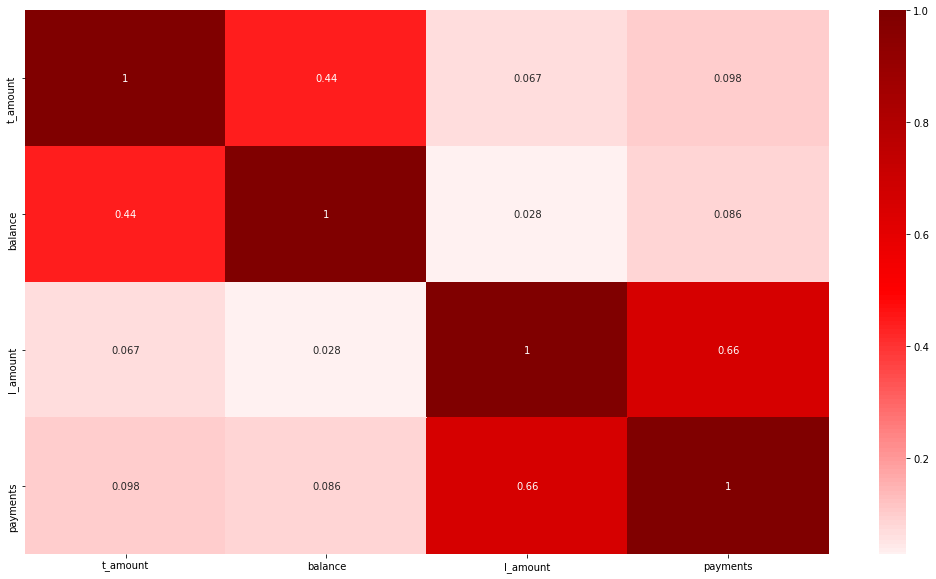

In [28]:
fig, ax = plt.subplots(figsize = (18, 10))
sns.heatmap(corr_matrix, cmap ='seismic', center = 0, annot=True);

#note

-some high correlations between my features

-come back here after first model validation and maybe drop the highly correlated features

## Explore data visually

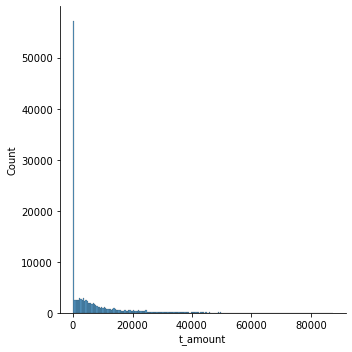

In [29]:
sns.displot(data['t_amount'])

In [30]:
data['t_amount'].describe()

count    145336.000000
mean       8127.276145
std       12047.666621
min           0.000000
25%         133.800000
50%        2758.000000
75%       11000.000000
max       87300.000000
Name: t_amount, dtype: float64

/Users/lilmac/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


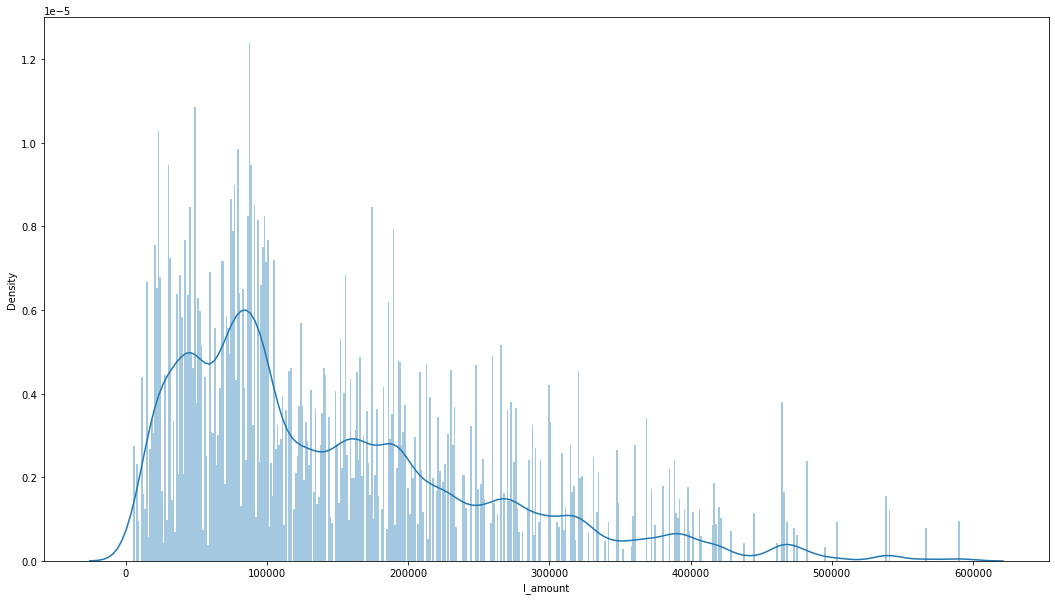

In [31]:
fig, ax = plt.subplots(figsize = (18, 10))
sns.distplot(data['l_amount'], bins=500);

In [32]:
data['l_amount'].describe()

count    145336.000000
mean     146015.695162
std      109476.855709
min        4980.000000
25%       65184.000000
50%      110736.000000
75%      200976.000000
max      590820.000000
Name: l_amount, dtype: float64

In [33]:
# because the values of these two columns are so far away from each other, 
# for our ML model to work we need to normalise these two

In [34]:
# l_amount's max values are 59 hundred thousand and t_amount is 87thousand

# Preprocessing step 1: 
### Normalise

In [49]:
import numpy as np
from sklearn.preprocessing import Normalizer
X = data.select_dtypes(include = np.number)

In [50]:
X.head(25)

,t_amount,balance,l_amount,payments
62,44749.0,45549.0,79608.0,3317.0
63,1000.0,1000.0,52788.0,4399.0
69,1100.0,1100.0,21924.0,609.0
75,700.0,700.0,23052.0,1921.0
96,900.0,900.0,41904.0,3492.0
98,900.0,900.0,65184.0,5432.0
106,1100.0,1100.0,76908.0,6409.0
107,19961.0,21061.0,76908.0,6409.0
122,1000.0,1000.0,105804.0,2939.0
129,17.0,21078.0,76908.0,6409.0


In [51]:
transformer = Normalizer().fit(X)
x_normalized = transformer.transform(X)

In [54]:
X = pd.DataFrame(x_normalized, columns=X.columns)

In [63]:
X['t_amount'].describe()

count    145336.000000
mean          0.063047
std           0.095218
min           0.000000
25%           0.000989
50%           0.020555
75%           0.086962
max           0.857956
Name: t_amount, dtype: float64

In [64]:
X['l_amount'].describe()

count    145336.000000
mean          0.856539
std           0.182564
min           0.072344
25%           0.805386
50%           0.936930
75%           0.981320
max           0.999861
Name: l_amount, dtype: float64

# Preprocessing step 2:
### Turn categorical data into boolean values

In [65]:
num = data._get_numeric_data()
cat = data.drop(columns=num.columns)

In [66]:
# dropping status column as that's what we wanna predict
cat = cat.drop(['status'], axis=1)

In [67]:
cat.head()

,type,operation,k_symbol,duration
62,PRIJEM,prevod,unknown,24.0
63,PRIJEM,vklad,unknown,12.0
69,PRIJEM,vklad,unknown,36.0
75,PRIJEM,vklad,unknown,12.0
96,PRIJEM,vklad,unknown,12.0


In [72]:
categorical = pd.get_dummies(cat, columns=['type', 'operation', 'k_symbol', 'duration'])

# Modeling

In [73]:
X.head()

,t_amount,balance,l_amount,payments
0,0.438261,0.446096,0.779661,0.032486
1,0.018872,0.018872,0.996191,0.083016
2,0.050028,0.050028,0.997109,0.027697
3,0.030234,0.030234,0.995634,0.082970
4,0.021394,0.021394,0.996090,0.083007


In [75]:
categorical.head()

,type_PRIJEM,type_VYBER,type_VYDAJ,operation_prevod,operation_unknown,operation_vklad,operation_vyber,k_symbol_SIPO,k_symbol_SLUZBY,k_symbol_UROK,k_symbol_unknown,duration_12.0,duration_24.0,duration_36.0,duration_48.0,duration_60.0
62,1,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0
63,1,0,0,0,0,1,0,0,0,0,1,1,0,0,0,0
69,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0
75,1,0,0,0,0,1,0,0,0,0,1,1,0,0,0,0
96,1,0,0,0,0,1,0,0,0,0,1,1,0,0,0,0


In [77]:
y = data['status']

In [78]:
len(x), len(y), len(data)

(145336, 145336, 145336)

In [81]:
# bring the numerical data (scaled)in with the categorical
X = np.concatenate((x_normalized, categorical),axis=1)

## TT split, get model

In [82]:
from sklearn.linear_model import LogisticRegression

In [83]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test =train_test_split(X, y, test_size= 0.4, random_state=40)

## Apply model and train model 

In [86]:
classification = LogisticRegression(random_state=0, solver='lbfgs',max_iter=400,
                  multi_class='ovr').fit(X_train, y_train)

## Evaluate accuracy and test 

In [87]:
from sklearn.metrics import accuracy_score 
predictions = classification.predict(X_test)

In [88]:
predictions

array(['C', 'A', 'C', ..., 'C', 'C', 'A'], dtype=object)

In [89]:
accuracy_score(y_test, predictions)

0.7077492044379462